# ÉVALUATION DE L’ÉQUITÉ DES MODÈLES D’APPRENTISSAGE PROFOND PRÉENTRAÎNÉS
# III. Apprentissage de ResNet50 avec fine tuning
# Projet de 15 crédits de Wajih Mghazli

In [1]:
from fairness_sdk.data_preparation import RAFDB_subgroups_init, RAFDB_loader_api
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

2023-05-18 12:45:50.829251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 12:45:53.042927: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 12:46:00.196078: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/export/livia/home/vision/Wmghazli/miniconda3/envs/tf/lib/
2023-05-18 12:46:00.197546:

## 1. Chargement des données de RAF-DB
### 1. 1 Définition des constantes (chemin de la BD, dimensions, etc.)

In [2]:
FEATURES_PATH = 'dataset/RAF/basic/Image/aligned/'
ANNOTATIONS_PATH = 'dataset/RAF/basic/Annotation/manual/Landmarks_5/'
LABELS_PATH = 'dataset/RAF/basic/EmoLabel/list_patition_label.txt'
img_rows, img_cols, img_channels, num_classes = 224, 224, 3, 7

### 1. 2 Chargement des données

In [3]:
raf_db = RAFDB_loader_api(FEATURES_PATH, ANNOTATIONS_PATH, LABELS_PATH, True)

### 1. 3 Initialisation des sous-groupes

In [4]:
train_images_gender, train_labels_gender, train_images_race, train_labels_race = RAFDB_subgroups_init()

### 1. 4. 1 Séparation des sous-groupes (pour la visualisation)

In [5]:
train_images_gender['male'] = np.array(raf_db['images_gender']['male'])
train_labels_gender['male'] = np.array(raf_db['labels_gender']['male'])
train_images_gender['female'] = np.array(raf_db['images_gender']['female'])
train_labels_gender['female'] = np.array(raf_db['labels_gender']['female'])

train_images_race['caucasian'] = np.array(raf_db['images_race']['caucasian'])
train_labels_race['caucasian'] = np.array(raf_db['labels_race']['caucasian'])
train_images_race['asian'] = np.array(raf_db['images_race']['asian'])
train_labels_race['asian'] = np.array(raf_db['labels_race']['asian'])
train_images_race['african'] = np.array(raf_db['images_race']['african'])
train_labels_race['african'] = np.array(raf_db['labels_race']['african'])

### 1. 4. 2 Reconstruction de la base de données

In [9]:
# Combine the subgroups into a single dataset
train_images = np.concatenate((train_images_gender['male'], train_images_gender['female'], train_images_race['caucasian'], train_images_race['asian'], train_images_race['african']), axis=0)
train_labels = np.concatenate((train_labels_gender['male'], train_labels_gender['female'], train_labels_race['caucasian'], train_labels_race['asian'], train_labels_race['african']), axis=0)

## 2. Apprentissage de ResNet50 avec fine tuning

In [10]:
# Instantiate the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channels))

# Add a global average pooling layer and a dense layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top 10 layers (fine tuning)
for layer in model.layers[-10:]:
    layer.trainable = True

# Compile the model
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
batch_size = 32

2023-05-18 12:49:34.429702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 12:49:42.530356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46705 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6
2023-05-18 12:49:42.536393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46705 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:31:00.0, compute capability: 8.6
2023-05-18 12:49:42.542254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/t

In [11]:
# Define checkpoint and early stopping callbacks
checkpoint_dir = './checkpoints'
checkpoint_file = checkpoint_dir + '/best_fine_tuned_resnet50.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_file, monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [12]:
history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=100, validation_split=0.2, callbacks=[checkpoint, early_stop], verbose=1)

Epoch 1/100


2023-05-18 12:50:32.822147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-18 12:50:41.145216: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-18 12:50:46.665807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


614/614 [==============================] - 74s 74ms/step - loss: 0.9954 - accuracy: 0.6485 - val_loss: 0.7352 - val_accuracy: 0.7486
Epoch 2/100
614/614 [==============================] - 38s 62ms/step - loss: 0.4951 - accuracy: 0.8332 - val_loss: 0.4450 - val_accuracy: 0.8425
Epoch 3/100
614/614 [==============================] - 38s 61ms/step - loss: 0.2065 - accuracy: 0.9400 - val_loss: 0.1302 - val_accuracy: 0.9627
Epoch 4/100
614/614 [==============================] - 37s 61ms/step - loss: 0.0691 - accuracy: 0.9835 - val_loss: 0.0899 - val_accuracy: 0.9688
Epoch 5/100
614/614 [==============================] - 35s 57ms/step - loss: 0.0551 - accuracy: 0.9845 - val_loss: 0.1005 - val_accuracy: 0.9650
Epoch 6/100
614/614 [==============================] - 34s 55ms/step - loss: 0.0307 - accuracy: 0.9921 - val_loss: 0.1670 - val_accuracy: 0.9362
Epoch 7/100
614/614 [==============================] - 35s 57ms/step - loss: 0.0538 - accuracy: 0.9827 - val_loss: 0.1527 - val_accuracy: 0.95

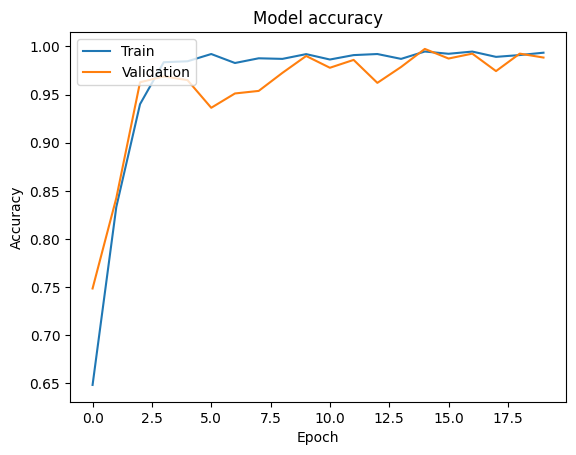

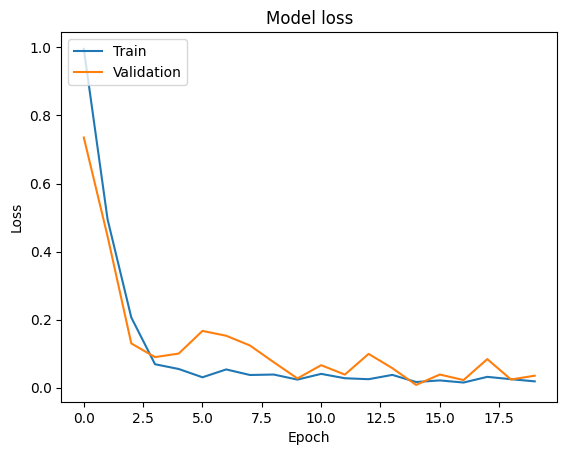

In [13]:
# Plot the accuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()